In [2]:
pip install deepchem
pip install tensorflow


  Using cached deepchem-2.5.0-py3-none-any.whl (552 kB)


In [1]:
import deepchem as dc


In [2]:
import rdkit as rdkit
import pandas as pd
import numpy as np
from rdkit import rdBase
from rdkit import Chem
from rdkit import RDConfig

from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import PandasTools
import os



In [3]:
# load files to continue

scams_filt = PandasTools.LoadSDF('scams_filt.sdf',smilesName='Smiles String',molColName='Molecule', includeFingerprints=False)

test_set = PandasTools.LoadSDF('test_set.sdf',smilesName='Smiles String',molColName='Molecule', includeFingerprints=False)

### Get RDKit descriptors

In [4]:
from rdkit.Chem import Descriptors

In [5]:
# function to derive descriptors from SMILES of the molecule
def smi_to_descriptors(smile):
    featurizer = dc.feat.RDKitDescriptors()
    features = featurizer.featurize(smile)
    return features


In [6]:
# apply the function to the column of SMILES
train_rdkit_desc_series = scams_filt['Smiles String'].apply(smi_to_descriptors)
test_rdkit_desc_series = test_set['Smiles String'].apply(smi_to_descriptors)



### Датасет в pandas

In [7]:
# two dataframes of features

train_rdkit_desc_df =  pd.DataFrame(train_rdkit_desc_series.map(lambda x: x[0]).tolist())
test_rdkit_desc_df = pd.DataFrame(test_rdkit_desc_series.map(lambda x: x[0]).tolist())

In [8]:
# dataframes of targets
train_y = scams_filt['agg?']
test_y = test_set['agg?']

In [9]:
# x and y in the one df
train_rdkit_desc_xy = pd.concat([train_rdkit_desc_df, train_y], axis=1)
test_rdkit_desc_xy = pd.concat([test_rdkit_desc_df, test_y], axis=1)

In [ ]:
# save this 
# !!!!поменять на сохранение в нампай!!!!
train_rdkit_desc_df.to_csv('train_rdkit_desc_df.csv')
test_rdkit_desc_df.to_csv('test_rdkit_desc_df.csv')
train_y.to_csv('train_y.csv')
test_y.to_csv('test_y.csv')
train_rdkit_desc_xy.to_csv('train_rdkit_desc_xy.csv')
test_rdkit_desc_xy.to_csv('test_rdkit_desc_xy1.csv')

### Numpy датасет

In [ ]:
# тут было преобразование в np.array но удалилось

# сохранить
np.savetxt("train_rdkit_desc_np.csv", train_rdkit_desc_np, delimiter=",")
np.savetxt("test_rdkit_desc_np.csv", test_rdkit_desc_np, delimiter=",")

np.savetxt("train_y_np.csv", train_y_np , delimiter=",")
np.savetxt("test_y_np.csv", test_y_np, delimiter=",")

In [8]:
# загрузить данные как np.array

from numpy import genfromtxt
train_rdkit_desc_np = genfromtxt('train_rdkit_desc_np.csv', delimiter=',')
test_rdkit_desc_np = genfromtxt('test_rdkit_desc_np.csv', delimiter=',')
train_y_np = genfromtxt('train_y_np.csv', delimiter=',')
test_y_np= genfromtxt('test_y_np.csv', delimiter=',')

In [ ]:
train_y_np[:, np.newaxis]
test_y_np[:, np.newaxis]

### deepchem model (not finished)

In [ ]:
#  create a dataset for the  deepchem

train_dataset = dc.data.NumpyDataset(train_rdkit_desc_np, train_y_np)

In [ ]:
# normalise data

#transformers = [
    #dc.trans.NormalizationTransformer(
    #transform_y=True, dataset=train_dataset, move_mean=True)
#]
#for transformer in transformers:
    #train_dataset = transformer.transform(train_dataset)

### Scikit classifier model

In [10]:
import sklearn
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [11]:
#metrics
from sklearn import metrics
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.metrics import  accuracy_score, f1_score

In [12]:
# create datasets
X_train, X_test, y_train, y_test = train_rdkit_desc_np, test_rdkit_desc_np, train_y_np, test_y_np

In [23]:
model_scikit_SDGC = make_pipeline(preprocessing.StandardScaler(), SGDClassifier())


In [24]:
parameters = {'sgdclassifier__loss':('hinge', 'log', 'modified_huber'),
              'sgdclassifier__penalty':('l2', 'l1', 'elasticnet'), 
              }
clfGSCV = GridSearchCV(model_scikit_SDGC, parameters, cv=10)


In [25]:
clfGSCV.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'sgdclassifier__loss': ('hinge', 'log',
                                                 'modified_huber'),
                         'sgdclassifier__penalty': ('l2', 'l1', 'elasticnet')})

In [ ]:
#print(clfGSCV.best_params_)

In [26]:
# model with best hyperparameters
model_SDGC = make_pipeline(preprocessing.StandardScaler(), 
                           SGDClassifier(loss = 'log', penalty =  'l2'))

In [70]:
model_SDGC.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(loss='log'))])

In [71]:
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

scoring=('roc_auc', 'accuracy', 'f1')

sdg_cv_results = cross_validate(model_SDGC, X_train, y_train, cv=kf, 
                                scoring=scoring, return_train_score=False)



In [72]:
# matthews correlation coefficient

y_pred_model_SDGC = model_SDGC.predict(X_test)
matthews_corrcoef(y_test, y_pred_model_SDGC)

0.6700306135801345

### Cat Boost

In [30]:
import catboost

In [ ]:
# fit catboost model
catb_model = make_pipeline(preprocessing.StandardScaler(), catboost.CatBoostClassifier(n_estimators=200)) 

catb_model.fit(train_rdkit_desc_np, train_y_np)

In [ ]:
#cross validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

scoring=('roc_auc', 'accuracy', 'f1')

catb_cv_results = cross_validate(catb_model, X_train, y_train, cv=kf, 
                            scoring=scoring, return_train_score=False)


In [34]:
# matthews correlation coeffitient
y_pred_catb = catb_model.predict(X_test)

matthews_corrcoef(y_test, y_pred_catb)

0.5209100196548825

In [ ]:
# save model

#catb_model.save_model(fname = 'catb_model',
           #format="cbm",
           #export_parameters=None,
           #pool=None)

### XGBoost

In [36]:
import xgboost as xgb
from xgboost import plot_importance

In [37]:
import warnings
warnings.simplefilter('ignore')
from xgboost import XGBClassifier

from sklearn.metrics import classification_report

In [39]:
xgb_model = make_pipeline(preprocessing.StandardScaler(), xgb.XGBClassifier(max_depth = 5, alpha = 10, n_estimators = 20))

In [47]:
#cross validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

scoring=('roc_auc', 'accuracy', 'f1')

xgb_cv_results = cross_validate(xgb_model, X_train, y_train, cv=kf, 
                            scoring=scoring, return_train_score=False)



[05:08:47] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:08:47] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:08:47] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:08:47] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

In [48]:
xgb_model.fit(X_train, y_train)

[05:08:51] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(alpha=10, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=20,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=10, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               ver

In [55]:
y_pred_xgb = xgb_model.predict(X_test)

matthews_corrcoef(y_test, y_pred_xgb)

0.4789351256229665

### LighBGM

In [50]:
import lightgbm as lgb
# test classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier

In [51]:
# define the model

lgbm_model = make_pipeline(preprocessing.StandardScaler(), LGBMClassifier())

In [52]:
#cross validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

scoring=('roc_auc', 'accuracy', 'f1')

lgbm_cv_results = cross_validate(lgbm_model, X_train, y_train, cv=kf, 
                            scoring=scoring, return_train_score=False)


In [53]:
lgbm_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier', LGBMClassifier())])

In [54]:
y_pred_lgbm = lgbm_model.predict(X_test)

matthews_corrcoef(y_test, y_pred_lgbm)

0.4081456382329668

### Violin Plot

In [56]:
# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
df_metrics = pd.DataFrame() 


In [58]:
df1  = pd.DataFrame(sdg_cv_results)
df1['model'] = 'SDGClassifier'
df2  = pd.DataFrame(catb_cv_results)
df2['model'] = 'CatBoost'
df3  = pd.DataFrame(xgb_cv_results)
df3['model'] = 'Xboost'
df4  = pd.DataFrame(lgbm_cv_results)
df4['model'] = 'LightBGM'

In [59]:
df_metrics = pd.concat([df1, df2, df3, df4])

In [60]:
df_metrics = df_metrics.reset_index(drop=True, inplace=False)

In [61]:
df_metrics[7:12]

,fit_time,score_time,test_roc_auc,test_accuracy,test_f1,model
7,0.041887,0.001994,0.921995,0.835165,0.716981,SDGClassifier
8,0.030917,0.001996,0.827524,0.711111,0.500000,SDGClassifier
9,0.057846,0.001994,0.859182,0.733333,0.586207,SDGClassifier
10,2.250796,0.021940,0.889941,0.846154,0.681818,CatBoost
11,2.539558,0.014960,0.862842,0.802198,0.666667,CatBoost


In [63]:
roc_auc = df_metrics.test_roc_auc
accuracy = df_metrics.test_accuracy
f1 = df_metrics.test_f1
model = df_metrics.model

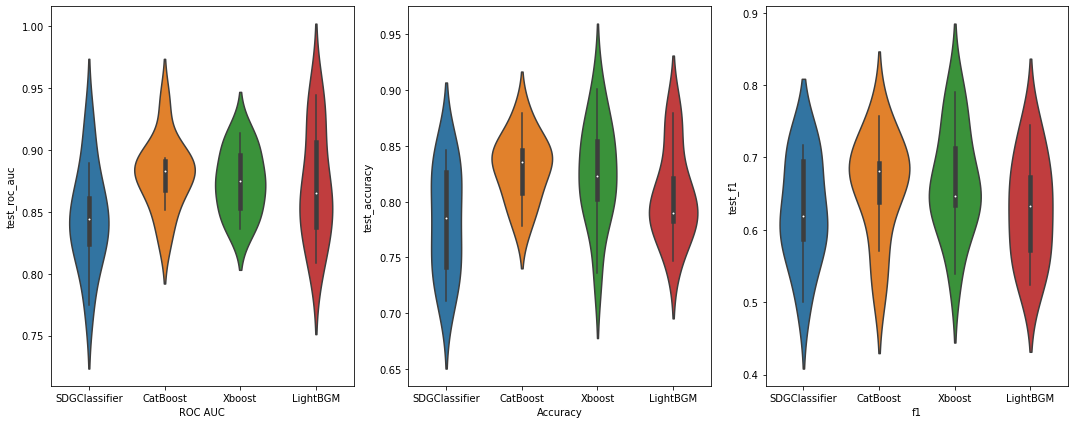

In [65]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(1, 4)

ax = fig.add_subplot(gs[0, 0])
sns.violinplot(x=model, y=roc_auc, data=df_metrics)
ax.set_xlabel("ROC AUC")

ax = fig.add_subplot(gs[0, 1])
sns.violinplot(x=model, y=accuracy, data=df_metrics)
ax.set_xlabel("Accuracy")

ax = fig.add_subplot(gs[0, 2])
sns.violinplot(x=model, y=f1, data=df_metrics)
ax.set_xlabel("f1")

fig.tight_layout()
plt.show()


In [66]:
fig.savefig('violin_models.png')

### Radar Chart

In [73]:
def derive_scores (clf, y_true = y_test, X_test = X_test):
    y_pred = clf.predict(X_test)
    scores_list = []
    scores_list.append(accuracy_score(y_true, y_pred))
    scores_list.append(f1_score(y_true, y_pred))
    scores_list.append(matthews_corrcoef(y_true, y_pred))
    scores_list.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    return scores_list
    


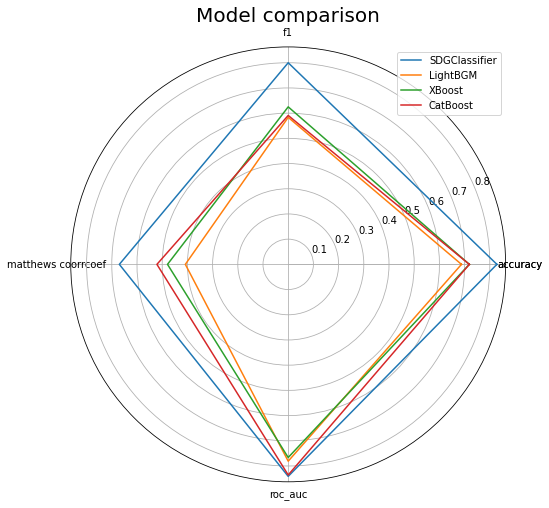

In [74]:
categories = ['accuracy', 
              'f1', 'matthews coorrcoef','roc_auc']
categories = [*categories, categories[0]]

SDGClassifier = derive_scores(model_SDGC)
LightBGM = derive_scores(lgbm_model)
XBoost = derive_scores(xgb_model)
CatBoost = derive_scores(catb_model)


SDGClassifier= [*SDGClassifier, SDGClassifier[0]]
LightBGM  = [*LightBGM, LightBGM[0]]
XBoost =  [*XBoost, XBoost[0]]
CatBoost  =  [*CatBoost, CatBoost[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(SDGClassifier))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, SDGClassifier, label='SDGClassifier')
plt.plot(label_loc, LightBGM , label='LightBGM ')
plt.plot(label_loc, XBoost, label='XBoost')
plt.plot(label_loc, CatBoost, label='CatBoost')

plt.title('Model comparison', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()